In [ ]:
import pandas as pd
import numpy as np
import re
import os
import scipy.stats as stats

# Read the data
df = pd.read_csv('atp_matches_2020-2024.csv', skiprows=3)

# Filter data for Masters (M) and Grand Slams (G)
dfFiltered = df[df['tourney_level'].isin(['M', 'G'])]

# Check results
print(f"Original number of matches: {len(df)}")
print(f"Filtered number of matches: {len(dfFiltered)}")

# Save the new data
dfFiltered.to_csv('masters_GS_2000-2024.csv', index=False)
print("File saved successfully.")

# Get columns with NA values
naColumnsInfo = dfFiltered.isnull().sum()
naColumnsToProcess = naColumnsInfo[naColumnsInfo > 0]

for col in naColumnsToProcess.index:
    # Fill NA values with the mean for numeric columns
    if pd.api.types.is_numeric_dtype(dfFiltered[col]):
        colMean = dfFiltered[col].mean()
        dfFiltered[col] = dfFiltered[col].fillna(colMean)

def analyzeMatchToughness(score, bestOf):
    """
    Analyzes the score to extract toughness metrics:
    1. Comeback Weight: 3.0 (0-2 down), 1.5 (0-1 or 1-2 down)
    2. Tiebreaks: Number of tiebreaks won and lost by the winner
    3. Deciding Set: Boolean, true if the match went the full distance
    """
    if pd.isna(score) or score == "" or "RET" in str(score) or "W/O" in str(score):
        return 0.0, 0, 0, False

    setsStr = score.split(' ')
    cleanedSets = []

    tbWon = 0
    tbLost = 0

    for s in setsStr:
        # Check for Tiebreaks (7-6 or 6-7)
        if "7-6" in s:
            tbWon += 1
        elif "6-7" in s:
            tbLost += 1

        match = re.match(r'(\d+)-(\d+)', s)
        if match:
            cleanedSets.append((int(match.group(1)), int(match.group(2))))

    if not cleanedSets:
        return 0.0, 0, 0, False

    #  Deciding Set
    isDecidingSet = (len(cleanedSets) == bestOf)

    #  Comeback
    comebackWeight = 0.0
    if bestOf == 3:
        if len(cleanedSets) >= 2:
            s1W, s1L = cleanedSets[0]
            if s1W < s1L: # Down 0-1
                comebackWeight = 1.5
    elif bestOf == 5:
        if len(cleanedSets) >= 3:
            s1W, s1L = cleanedSets[0]
            s2W, s2L = cleanedSets[1]
            if s1W < s1L and s2W < s2L: # Down 0-2
                comebackWeight = 3.0
            else:
                # Check for 1-2 down
                first3 = cleanedSets[:3]
                winnerSets = sum(1 for w, l in first3 if w > l)
                if winnerSets == 1:
                    comebackWeight = 1.5

    return comebackWeight, tbWon, tbLost, isDecidingSet

def calculateClutchIndex():
    print("Loading datasets...")

    # File names
    fileHistory = 'masters&GS_2000-2024.csv'
    fileRecent = 'atp_matches_2020-2024.csv'

    # Check / Find files
    if not os.path.exists(fileHistory):
        fallback = 'masters_GS_2000-2024.csv'
        if os.path.exists(fallback):
            print(f"Found '{fallback}', using that alternatively.")
            fileHistory = fallback
        else:
            print(f"Error: '{fileHistory}' not found.")
            return None

    if not os.path.exists(fileRecent):
        print(f"Error: '{fileRecent}' not found.")
        return None

    try:
        dfHistory = pd.read_csv(fileHistory)
        dfRecent = pd.read_csv(fileRecent, skiprows=3)
    except Exception as e:
        print(f"Error reading CSV files: {e}")
        return None

    print(f"Recent matches before filter: {len(dfRecent)}")
    dfRecent = dfRecent[dfRecent['tourney_level'].isin(['M', 'G'])]
    print(f"Recent matches after filter: {len(dfRecent)}")

    # Merge Columns
    colsToKeep = ['tourney_id', 'match_num', 'surface', 'winner_name', 'loser_name',
                    'winner_age', 'loser_age', 'w_bpSaved', 'w_bpFaced',
                    'l_bpSaved', 'l_bpFaced', 'score', 'best_of']

    availableColsHistory = [c for c in colsToKeep if c in dfHistory.columns]
    availableColsRecent = [c for c in colsToKeep if c in dfRecent.columns]

    dfCombined = pd.concat([dfHistory[availableColsHistory], dfRecent[availableColsRecent]], ignore_index=True)

    # Remove duplicates
    dfCombined.drop_duplicates(subset=['tourney_id', 'match_num'], inplace=True)

    # Drop rows with missing critical stats
    dfCombined.dropna(subset=['w_bpFaced', 'l_bpFaced', 'winner_age'], inplace=True)

    # Global Mean Age
    globalMeanAge = dfCombined['winner_age'].mean()
    print(f"Global Mean Winning Age: {globalMeanAge:.2f}")

    # Apply analysis row by row
    analysisResults = dfCombined.apply(lambda row: analyzeMatchToughness(row['score'], row['best_of']), axis=1)
    dfCombined[['comeback_score', 'w_tb_won', 'w_tb_lost', 'is_decider']] = pd.DataFrame(analysisResults.tolist(), index=dfCombined.index)

    # Winners perspective
    winners = dfCombined.copy()
    winners['player_name'] = winners['winner_name']
    winners['age'] = winners['winner_age']
    winners['bp_saved'] = winners['w_bpSaved']
    winners['bp_faced'] = winners['w_bpFaced']
    winners['tb_won'] = winners['w_tb_won']
    winners['tb_lost'] = winners['w_tb_lost']
    winners['decider_won'] = winners['is_decider'].astype(int)
    winners['decider_played'] = winners['is_decider'].astype(int)
    winners['won_match'] = 1 # WIN

    # Losers perspective
    losers = dfCombined.copy()
    losers['player_name'] = losers['loser_name']
    losers['age'] = losers['loser_age']
    losers['bp_saved'] = losers['l_bpSaved']
    losers['bp_faced'] = losers['l_bpFaced']
    losers['tb_won'] = losers['w_tb_lost']
    losers['tb_lost'] = losers['w_tb_won']
    losers['decider_won'] = 0
    losers['decider_played'] = losers['is_decider'].astype(int)
    losers['comeback_score'] = 0.0
    losers['won_match'] = 0 # LOSS

    playerStats = pd.concat([
        winners[['player_name', 'surface', 'age', 'bp_saved', 'bp_faced', 'comeback_score', 'tb_won', 'tb_lost', 'decider_won', 'decider_played', 'won_match']],
        losers[['player_name', 'surface', 'age', 'bp_saved', 'bp_faced', 'comeback_score', 'tb_won', 'tb_lost', 'decider_won', 'decider_played', 'won_match']]
    ])

    # Calculation Logic
    def getIndex(dfGroup, globalAgeMean):
        matchCount = len(dfGroup)
        if matchCount < 30: # Minimum matches threshold
            return None

        # 1. Adjusted Win Rate (Bayesian Calculation)
        totalWins = dfGroup['won_match'].sum()

        # PARAMETERS
        C = 50   # Confidence weight (matches added)
        m = 0.50 # Global average win rate

        rawWinRate = totalWins / matchCount
        adjustedWinRate = (totalWins + (C * m)) / (matchCount + C)

        # 2. Clutch Metrics
        # a. Break Points (40%)
        totalBpSaved = dfGroup['bp_saved'].sum()
        totalBpFaced = dfGroup['bp_faced'].sum()
        bpRatio = totalBpSaved / totalBpFaced if totalBpFaced > 0 else 0
        scoreBp = bpRatio * 40

        # b. Tie-Breaks (20%)
        totalTbWon = dfGroup['tb_won'].sum()
        totalTbPlayed = totalTbWon + dfGroup['tb_lost'].sum()
        if totalTbPlayed >= 5:
            tbRatio = totalTbWon / totalTbPlayed
            scoreTb = tbRatio * 20
        else:
            scoreTb = 10

        # c. Deciding Sets (20%)
        totalDecidersWon = dfGroup['decider_won'].sum()
        totalDecidersPlayed = dfGroup['decider_played'].sum()
        if totalDecidersPlayed >= 5:
            deciderRatio = totalDecidersWon / totalDecidersPlayed
            scoreDecider = deciderRatio * 20
        else:
             scoreDecider = 10

        # d. Comeback Rate (Max 30 pts)
        totalComebackPts = dfGroup['comeback_score'].sum()
        avgComebackPts = totalComebackPts / matchCount
        scoreComeback = min(avgComebackPts * 400, 30)

        # e. Longevity Bonus
        scoreLongevity = np.log10(matchCount) * 5

        # f. Dominance Bonus (Straight Sets Wins)
        # Matches won without playing a decider (2-0 or 3-0)
        straightWins = dfGroup[(dfGroup['decider_played'] == 0) & (dfGroup['won_match'] == 1)].shape[0]
        dominanceRatio = straightWins / matchCount
        scoreDominance = dominanceRatio * 20

        # Total Base Score
        baseScore = scoreBp + scoreTb + scoreDecider + scoreComeback + scoreLongevity + scoreDominance

        # Age Multiplier
        playerMeanAge = dfGroup['age'].mean()
        ageDiff = abs(playerMeanAge - globalAgeMean)
        ageMultiplier = 1 + (0.05 * ageDiff)

        finalClutchIndex = baseScore * ageMultiplier


        return pd.Series({
        'Matches': matchCount,
        'Wins': totalWins,
        'Raw_Win_Rate': rawWinRate,
        'Adjusted_Win_Rate': adjustedWinRate,
        'Clutch_Index': finalClutchIndex,
        'BP_Ratio': bpRatio,
        'TB_Ratio': tbRatio if totalTbPlayed >= 5 else np.nan,
        'Decider_Ratio': deciderRatio if totalDecidersPlayed >= 5 else np.nan,
        'Dominance_Ratio': dominanceRatio,
        'Comeback_Score': scoreComeback
        })
    print("\n--- Processing Overall Clutch Index ---")
    overallStats = playerStats.groupby('player_name').apply(getIndex, globalMeanAge)
    overallStats = overallStats.dropna().sort_values(by='Clutch_Index', ascending=False)

    print("\n--- Processing Surface Specific Clutch Index ---")
    surfaceStats = playerStats.groupby(['player_name', 'surface']).apply(getIndex, globalMeanAge)
    surfaceStats = surfaceStats.dropna().sort_values(by='Clutch_Index', ascending=False)

    return overallStats, surfaceStats

# 4. HYPOTHESIS TESTING
def performHypothesisTest(df):


    print("   STATISTICAL HYPOTHESIS TESTING REPORT   ")

    # 1. Data Preparation
    cleanData = df.dropna(subset=['Clutch_Index', 'Adjusted_Win_Rate'])
    n = len(cleanData)

    x = cleanData['Clutch_Index']
    y = cleanData['Adjusted_Win_Rate']

    # 2. Define Hypotheses
    print(f"\n1. HYPOTHESES DEFINITION:")
    print(f"   Null Hypothesis (H0): There is NO correlation between a player's Clutch Index and their Adjusted Career Win Rate.")
    print(f"   Alt. Hypothesis (H1): There is a significant correlation between Clutch Index and Win Rate.")

    # 3. Calculate Pearson Correlation
    correlation, pValue = stats.pearsonr(x, y)

    print(f"\n2. TEST RESULTS (Sample Size: {n} players):")
    print(f"   Pearson Correlation (r): {correlation:.4f}")
    print(f"   P-Value                : {pValue:.4e}")

    # 4. Evaluation
    print(f"\n3. EVALUATION & INTERPRETATION:")

    if pValue < 0.05:
        print("    Result: Reject Null Hypothesis")
        print("       The relationship is Statistically Significant.")

        direction = "Positive" if correlation > 0 else "Negative"
        print(f"       Direction: {direction}")

        if direction == "Positive":
            print("       -> Players with higher Clutch Scores generally achieve higher Adjusted Win Rates.")
    else:
        print("       Result: Fail to reject the hypothesis")
        print("       The relationship is NOT Statistically Significant.")



if __name__ == "__main__":
    result = calculateClutchIndex()
    if result is not None:
        overallDf, surfaceDf = result

        # Save results
        overallDf.head(20).to_csv('top_20_clutch_players_overall_final.csv')
        surfaceDf.head(20).to_csv('top_20_clutch_players_surface_final.csv')

        print("\nTop 15 Overall Clutch Players (Sorted by Index):")
        pd.options.display.float_format = '{:.3f}'.format
        print(overallDf[['Matches', 'Wins', 'Raw_Win_Rate', 'Adjusted_Win_Rate', 'Clutch_Index']].head(15))

        print("\nTop 5 by Surface:")
        for surf in ['Hard', 'Clay', 'Grass']:
            print(f"\n--- {surf} ---")
            try:
                subset = surfaceDf.xs(surf, level=1).sort_values(by='Clutch_Index', ascending=False)
                print(subset[['Matches', 'Adjusted_Win_Rate', 'Clutch_Index']].head(5))
            except KeyError:
                print(f"No sufficient data for {surf}")


        performHypothesisTest(overallDf)
    else:
        print("Calculation failed.")

Original number of matches: 74906
Filtered number of matches: 26571
File saved successfully.
Loading datasets...
Found 'masters_GS_2000-2024.csv', using that alternatively.


/tmp/ipython-input-3438268159.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFiltered[col] = dfFiltered[col].fillna(colMean)


Recent matches before filter: 74906
Recent matches after filter: 26571
Global Mean Winning Age: 26.46

--- Processing Overall Clutch Index ---


/tmp/ipython-input-3438268159.py:251: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overallStats = playerStats.groupby('player_name').apply(getIndex, globalMeanAge)



--- Processing Surface Specific Clutch Index ---

Top 15 Overall Clutch Players (Sorted by Index):
                     Matches    Wins  Raw_Win_Rate  Adjusted_Win_Rate  \
player_name                                                             
Andre Agassi         215.000 170.000         0.791              0.736   
Carlos Alcaraz       155.000 123.000         0.794              0.722   
Gianluca Pozzi        30.000  14.000         0.467              0.487   
Holger Rune          100.000  63.000         0.630              0.587   
Jannik Sinner        183.000 139.000         0.760              0.704   
Guillermo Coria      162.000 112.000         0.691              0.646   
Ivo Karlovic         262.000 117.000         0.447              0.455   
Pete Sampras         100.000  74.000         0.740              0.660   
Roger Federer        909.000 746.000         0.821              0.804   
John Isner           386.000 232.000         0.601              0.589   
Andreas Vinciguerra   53

/tmp/ipython-input-3438268159.py:255: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  surfaceStats = playerStats.groupby(['player_name', 'surface']).apply(getIndex, globalMeanAge)



--- Starting Comprehensive Visualization Module ---
>> Saved: clutch_component_analysis.png


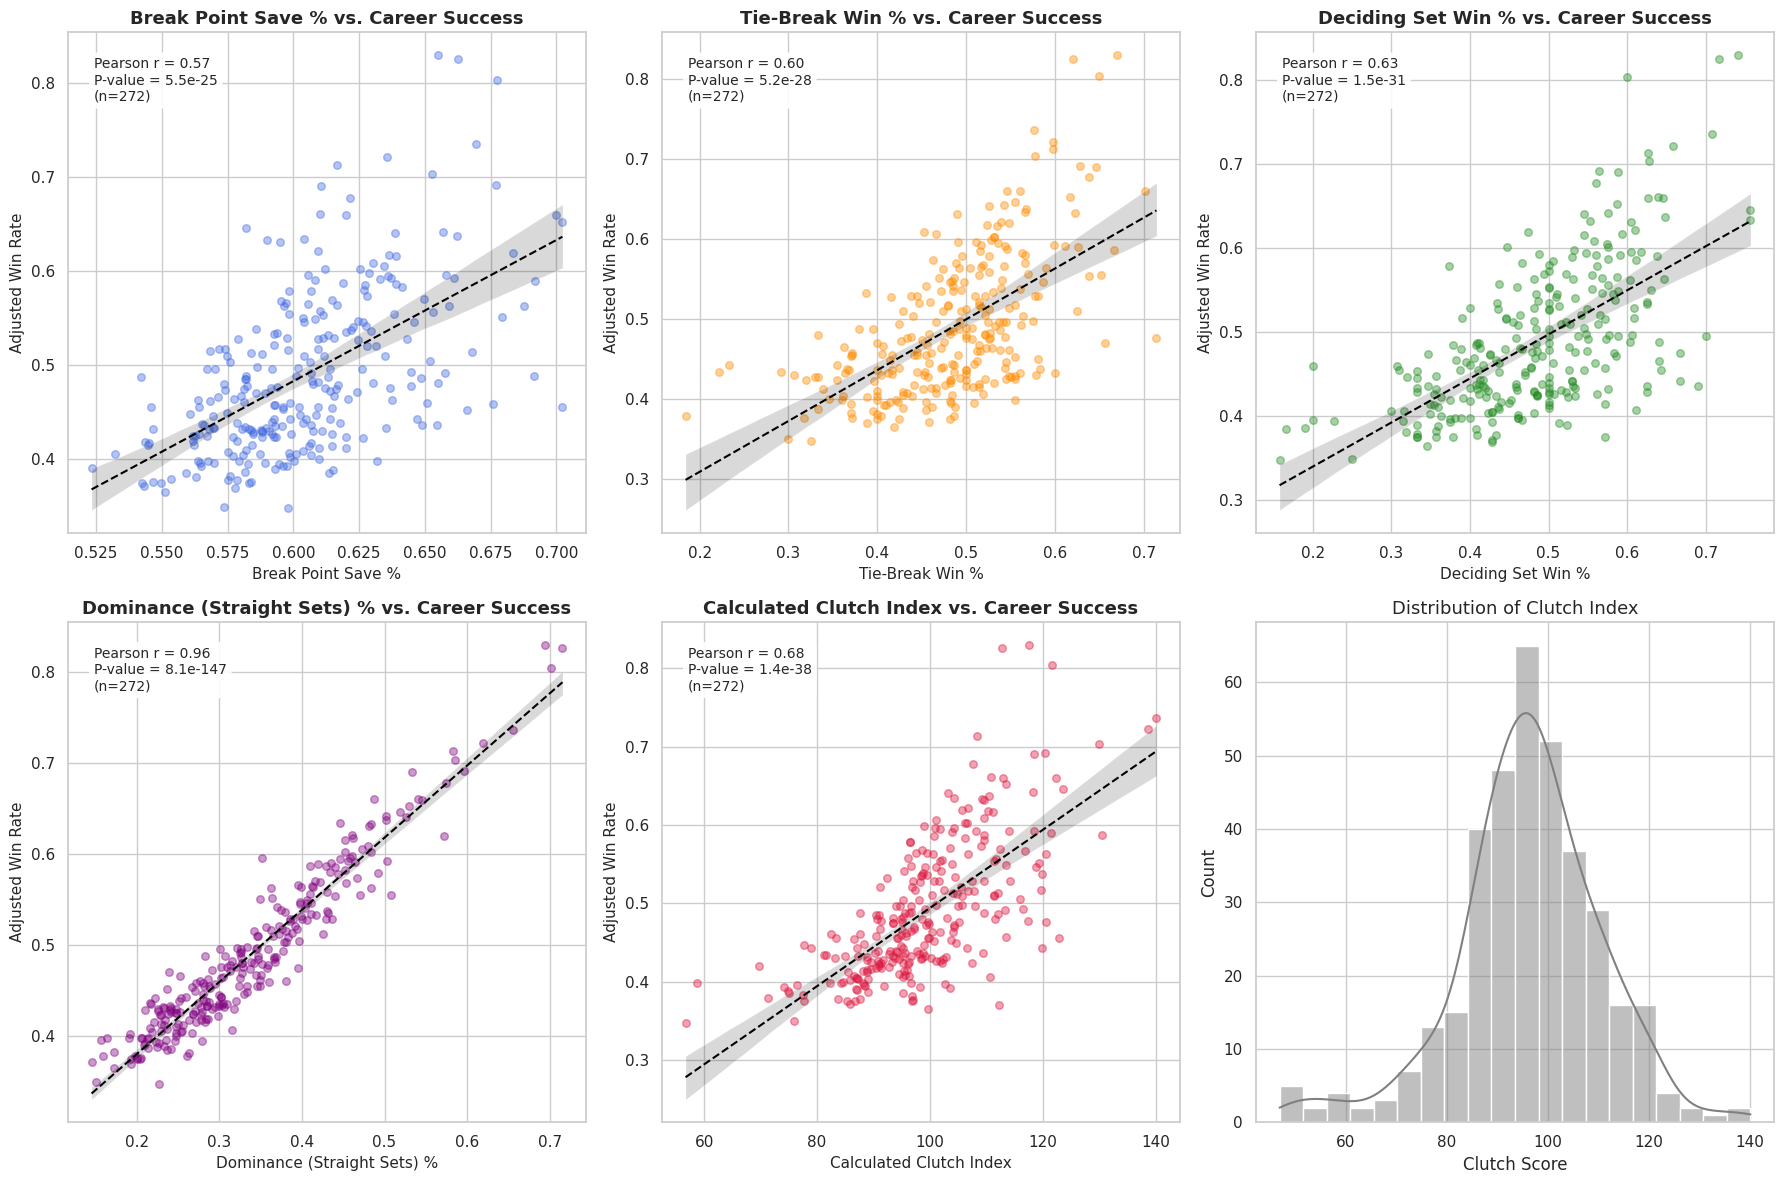

2. Generating Correlation Heatmap...
>> Saved: clutch_correlation_heatmap.png


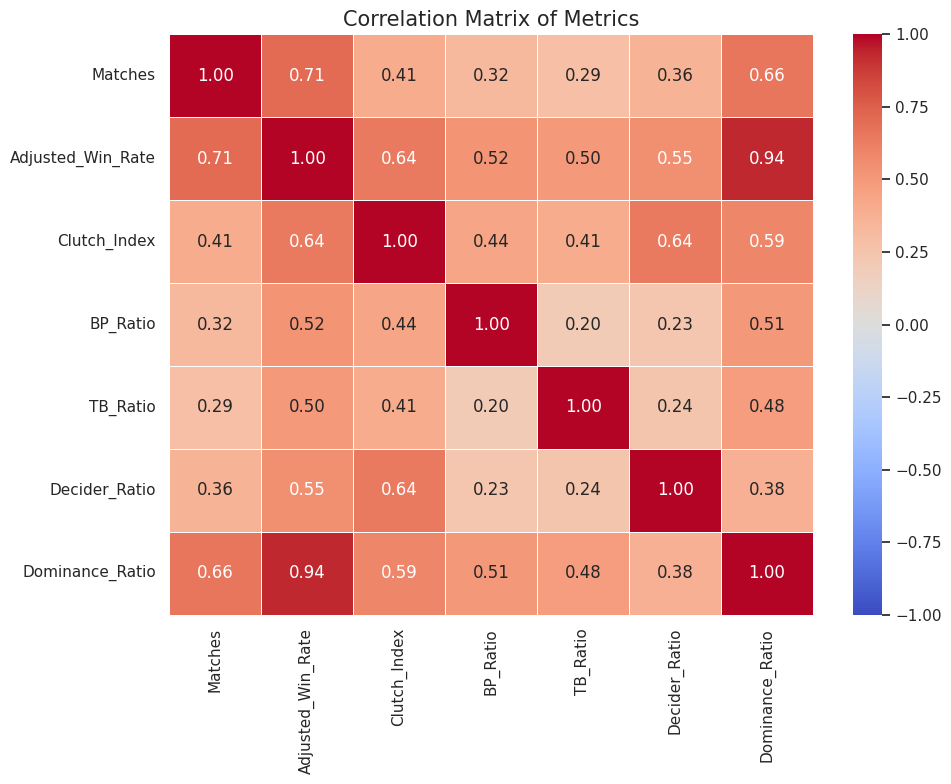

3. Generating Top 10 Leaderboard...


/tmp/ipython-input-367373255.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


>> Saved: top10_clutch_leaders.png


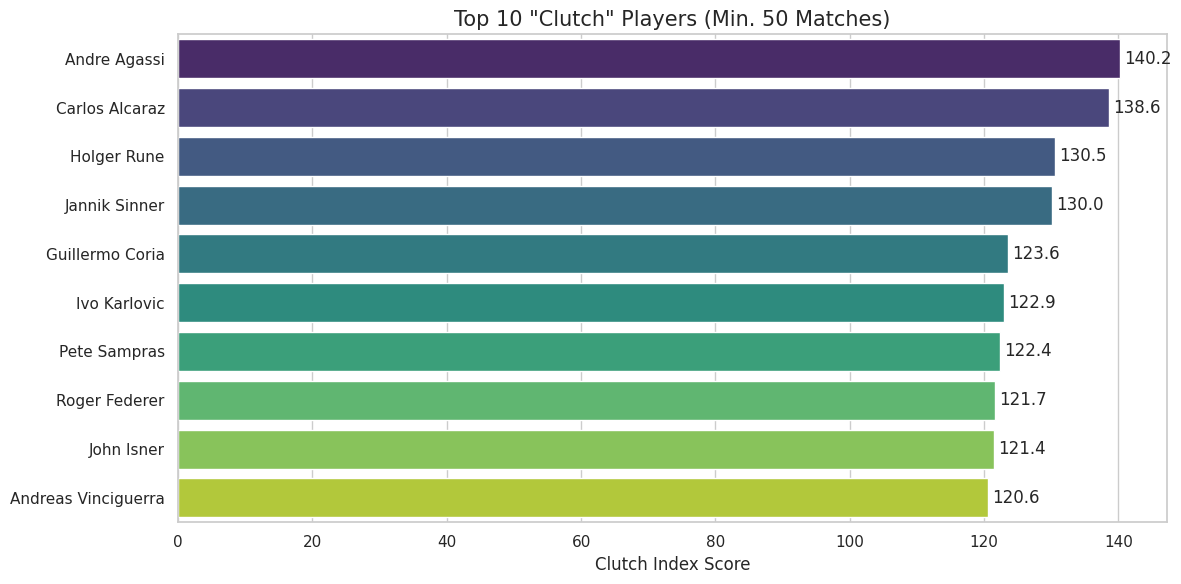

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np

def visualize_comprehensive_analysis(df):

    print("\n--- Starting Comprehensive Visualization Module ---")

    # General Seaborn theme settings (For a cleaner look)
    sns.set_theme(style="whitegrid", context="notebook")


    # Scatter Plots & Regression

    # Parameters to analyze, Titles, and Color Codes
    metrics_to_plot = [
        ('BP_Ratio', 'Break Point Save %', 'royalblue'),
        ('TB_Ratio', 'Tie-Break Win %', 'darkorange'),
        ('Decider_Ratio', 'Deciding Set Win %', 'forestgreen'),
        ('Dominance_Ratio', 'Dominance (Straight Sets) %', 'purple'),
        ('Clutch_Index', 'Calculated Clutch Index', 'crimson')
    ]

    # Create a plotting grid of 2 rows and 3 columns
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    axes = axes.flatten() # Flatten the matrix for easier iteration

    for i, (col_name, title, color) in enumerate(metrics_to_plot):
        ax = axes[i]

        # Check if column exists in the dataset
        if col_name not in df.columns:
            ax.text(0.5, 0.5, f"Data Not Found:\n{col_name}",
                    ha='center', va='center', fontsize=12, color='red')
            continue

        # Data Cleaning:
        # 1. Drop NaN values in the specific column or Win Rate.
        # 2. Filter for players with > 50 matches (prevents noise).
        plot_data = df.dropna(subset=[col_name, 'Adjusted_Win_Rate']).copy()
        plot_data = plot_data[plot_data['Matches'] > 50]

        # Skip if insufficient data remains after filtering
        if len(plot_data) < 5:
            ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center')
            continue

        # A) Scatter Plot and Regression Line
        sns.regplot(
            data=plot_data,
            x=col_name,
            y='Adjusted_Win_Rate',
            ax=ax,
            scatter_kws={'alpha': 0.4, 's': 30, 'color': color}, # Dot transparency and size
            line_kws={'color': 'black', 'linewidth': 1.5, 'linestyle': '--'} # Line style
        )

        # B) Statistical Calculation (Pearson Correlation)
        r, p = stats.pearsonr(plot_data[col_name], plot_data['Adjusted_Win_Rate'])

        # Print statistics on the top-left corner of the plot
        stats_text = f"Pearson r = {r:.2f}\nP-value = {p:.1e}\n(n={len(plot_data)})"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

        # Axis and Title Labels
        ax.set_title(f"{title} vs. Career Success", fontsize=13, fontweight='bold')
        ax.set_xlabel(title, fontsize=11)
        ax.set_ylabel("Adjusted Win Rate", fontsize=11)

    # Add Clutch Index Distribution to the 6th (empty) square
    ax_last = axes[5]
    if 'Clutch_Index' in df.columns:
        sns.histplot(df['Clutch_Index'], bins=20, kde=True, color='gray', ax=ax_last)
        ax_last.set_title("Distribution of Clutch Index", fontsize=13)
        ax_last.set_xlabel("Clutch Score")
    else:
        ax_last.axis('off') # Leave blank if data is missing

    plt.tight_layout()
    plt.savefig('clutch_component_analysis.png', dpi=300)
    print(">> Saved: clutch_component_analysis.png")
    plt.show()


    # PART 2: CORRELATION HEATMAP

    print("2. Generating Correlation Heatmap...")

    # Numeric columns to include in the heatmap
    cols_for_heatmap = ['Matches', 'Adjusted_Win_Rate', 'Clutch_Index',
                        'BP_Ratio', 'TB_Ratio', 'Decider_Ratio', 'Dominance_Ratio']

    # Select only available columns
    available_cols = [c for c in cols_for_heatmap if c in df.columns]

    if len(available_cols) > 1:
        plt.figure(figsize=(10, 8))

        # Calculate correlation matrix
        corr_matrix = df[available_cols].corr()

        # Draw Heatmap
        sns.heatmap(
            corr_matrix,
            annot=True,       # Write numbers in cells
            fmt=".2f",        # 2 decimal places
            cmap='coolwarm',  # Blue (Negative) - Red (Positive) palette
            vmin=-1, vmax=1,  # Scale range
            linewidths=0.5
        )
        plt.title('Correlation Matrix of Metrics', fontsize=15)
        plt.tight_layout()
        plt.savefig('clutch_correlation_heatmap.png', dpi=300)
        print(">> Saved: clutch_correlation_heatmap.png")
        plt.show()


    # PART 3: TOP 10 CLUTCH PLAYERS (BAR CHART)

    print("3. Generating Top 10 Leaderboard...")

    if 'Clutch_Index' in df.columns:
        # Select top 10 players with highest score (min 50 matches)
        top_players = df[df['Matches'] > 50].nlargest(10, 'Clutch_Index').reset_index()

        plt.figure(figsize=(12, 6))

        # Draw Bar Chart
        bar_plot = sns.barplot(
            data=top_players,
            x='Clutch_Index',
            y='player_name', # Ensure 'player_name' is a column, not just index
            palette='viridis'
        )

        plt.title('Top 10 "Clutch" Players (Min. 50 Matches)', fontsize=15)
        plt.xlabel('Clutch Index Score', fontsize=12)
        plt.ylabel(None)

        # Label the bars with values
        for i in bar_plot.containers:
            bar_plot.bar_label(i, fmt='%.1f', padding=3)

        plt.tight_layout()
        plt.savefig('top10_clutch_leaders.png', dpi=300)
        print(">> Saved: top10_clutch_leaders.png")
        plt.show()

#  EXECUTION BLOCK
if __name__ == "__main__":
    # Ensure overallDf is loaded in memory
    if 'overallDf' in locals():
        # Check for required columns
        required_cols = ['BP_Ratio', 'TB_Ratio']
        if any(col in overallDf.columns for col in required_cols):
            # Ensure player_name is available as a column for the Bar Chart
            if 'player_name' not in overallDf.columns:
                df_to_plot = overallDf.reset_index()
            else:
                df_to_plot = overallDf

            visualize_comprehensive_analysis(df_to_plot)
        else:
            print("WARNING: Required analysis columns are missing in 'overallDf'.")
    else:
        print("Please run the main calculation script first to generate 'overallDf'.")